## Training setup and Training Loop

In [24]:
"""
AgroWeather AI - LSTM Model Training
"""
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import pickle
import time
from pathlib import Path
import matplotlib.pyplot as plt
import sys

class EarlyStopping:
    """
    Early stopping to stop training when validation loss stops improving
    """
    def __init__(self, patience=10, min_delta=0.0001):
        """
        Args:
            patience (int): How many epochs to wait after last improvement
            min_delta (float): Minimum change to qualify as improvement
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        
    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0


In [25]:
def load_processed_data(data_dir='../../data/processed'):
    """
    Load preprocessed data for training
    """
    print("📂 Loading processed data...")
    
    X_train = np.load(f'{data_dir}/X_train.npy')
    X_val = np.load(f'{data_dir}/X_val.npy')
    X_test = np.load(f'{data_dir}/X_test.npy')
    
    y_train = np.load(f'{data_dir}/y_train.npy')
    y_val = np.load(f'{data_dir}/y_val.npy')
    y_test = np.load(f'{data_dir}/y_test.npy')
    
    # Load metadata
    with open(f'{data_dir}/metadata.pkl', 'rb') as f:
        metadata = pickle.load(f)
    
    print(f"✅ Data loaded successfully!")
    print(f"   Training samples: {len(X_train):,}")
    print(f"   Validation samples: {len(X_val):,}")
    print(f"   Test samples: {len(X_test):,}")
    print(f"   Features: {metadata['n_features']}")
    print(f"   Sequence length: {metadata['sequence_length']} days")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, metadata

In [26]:
def create_dataloaders(X_train, X_val, y_train, y_val, batch_size=32):
    """
    Create PyTorch DataLoaders for batch training
    """
    print(f"\n🔄 Creating DataLoaders (batch_size={batch_size})...")
    
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(X_train)
    y_train_tensor = torch.FloatTensor(y_train)
    X_val_tensor = torch.FloatTensor(X_val)
    y_val_tensor = torch.FloatTensor(y_val)
    
    # Create TensorDatasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    
    # Create DataLoaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  # Shuffle training data each epoch
        drop_last=True  # Drop last incomplete batch
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,  # Don't shuffle validation data
        drop_last=False
    )
    
    print(f"✅ DataLoaders created!")
    print(f"   Training batches: {len(train_loader)}")
    print(f"   Validation batches: {len(val_loader)}")
    
    return train_loader, val_loader

In [27]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    """
    Train for one epoch
    
    Returns:
        average training loss for this epoch
    """
    model.train()  # Set model to training mode
    
    epoch_loss = 0.0
    num_batches = 0
    
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        # Move data to device (GPU/CPU)
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        
        # Zero the gradients (clear from previous iteration)
        optimizer.zero_grad()
        
        # Forward pass (make predictions)
        predictions = model(X_batch)
        
        # Calculate loss
        loss = criterion(predictions, y_batch)
        
        # Backward pass (calculate gradients)
        loss.backward()
        
        # Gradient clipping (prevent exploding gradients)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Update weights
        optimizer.step()
        
        # Track loss
        epoch_loss += loss.item()
        num_batches += 1
    
    # Return average loss for this epoch
    avg_loss = epoch_loss / num_batches
    return avg_loss


def validate(model, val_loader, criterion, device):
    """
    Validate model on validation set
    
    Returns:
        average validation loss
    """
    model.eval()  # Set model to evaluation mode
    
    val_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():  # Don't calculate gradients (saves memory)
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            
            val_loss += loss.item()
            num_batches += 1
    
    avg_loss = val_loss / num_batches
    return avg_loss


def train_model(model, train_loader, val_loader, criterion, optimizer, 
                num_epochs=100, device='cpu', early_stopping_patience=15):
    """
    Complete training loop with early stopping
    """
    print(f"\n🎓 Starting training...")
    print(f"   Device: {device}")
    print(f"   Epochs: {num_epochs}")
    print(f"   Early stopping patience: {early_stopping_patience}")
    print("="*70)
    
    # Initialize tracking
    history = {
        'train_loss': [],
        'val_loss': [],
        'epochs': []
    }
    
    best_val_loss = float('inf')
    best_model_state = None
    early_stopping = EarlyStopping(patience=early_stopping_patience)
    
    start_time = time.time()
    
    # Training loop
    for epoch in range(1, num_epochs + 1):
        epoch_start = time.time()
        
        # Train one epoch
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validate
        val_loss = validate(model, val_loader, criterion, device)
        
        # Track history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['epochs'].append(epoch)
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()
            print(f"✨ New best model! Val Loss: {val_loss:.6f}")
        
        # Print progress
        epoch_time = time.time() - epoch_start
        print(f"Epoch {epoch:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:.6f} | "
              f"Val Loss: {val_loss:.6f} | "
              f"Time: {epoch_time:.2f}s")
        
        # Early stopping check
        early_stopping(val_loss)
        if early_stopping.early_stop:
            print(f"\n⏹️  Early stopping triggered at epoch {epoch}")
            print(f"   No improvement for {early_stopping_patience} epochs")
            break
    
    # Training complete
    total_time = time.time() - start_time
    print("\n" + "="*70)
    print(f"✅ Training completed!")
    print(f"   Total time: {total_time/60:.2f} minutes")
    print(f"   Best validation loss: {best_val_loss:.6f}")
    print(f"   Final epoch: {epoch}/{num_epochs}")
    
    # Restore best model
    model.load_state_dict(best_model_state)
    
    return model, history, best_val_loss


def save_model_and_history(model, history, best_val_loss, output_dir='models/saved'):
    """
    Save trained model and training history
    """
    print(f"\n💾 Saving model and training history...")
    
    # Create output directory
    Path(output_dir).mkdir(parents=True, exist_ok=True)
    
    # Save model weights
    model_path = f'{output_dir}/rainfall_lstm_best.pth'
    torch.save(model.state_dict(), model_path)
    print(f"   ✅ Model weights saved: {model_path}")
    
    # Save complete model (architecture + weights)
    full_model_path = f'{output_dir}/rainfall_lstm_full.pth'
    torch.save(model, full_model_path)
    print(f"   ✅ Full model saved: {full_model_path}")
    
    # Save training history
    history_path = f'{output_dir}/training_history.pkl'
    with open(history_path, 'wb') as f:
        pickle.dump(history, f)
    print(f"   ✅ Training history saved: {history_path}")
    
    # Save metadata
    metadata = {
        'best_val_loss': best_val_loss,
        'total_epochs': len(history['epochs']),
        'final_train_loss': history['train_loss'][-1],
        'final_val_loss': history['val_loss'][-1]
    }
    
    metadata_path = f'{output_dir}/training_metadata.pkl'
    with open(metadata_path, 'wb') as f:
        pickle.dump(metadata, f)
    print(f"   ✅ Metadata saved: {metadata_path}")


def plot_training_history(history, output_dir='outputs'):
    """
    Plot training and validation loss curves
    """
    print(f"\n📊 Creating training history plots...")
    
    plt.figure(figsize=(12, 6))
    
    # Plot losses
    plt.plot(history['epochs'], history['train_loss'], label='Training Loss', linewidth=2)
    plt.plot(history['epochs'], history['val_loss'], label='Validation Loss', linewidth=2)
    
    # Find best epoch
    best_epoch = history['epochs'][np.argmin(history['val_loss'])]
    best_val_loss = min(history['val_loss'])
    
    plt.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.7, 
                label=f'Best Model (Epoch {best_epoch})')
    
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('Loss (MSE)', fontsize=12)
    plt.title('LSTM Training History - Rainfall Prediction', fontsize=14, fontweight='bold')
    plt.legend(fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add text box with final metrics
    textstr = f'Best Val Loss: {best_val_loss:.6f}\nBest Epoch: {best_epoch}'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    plt.text(0.02, 0.98, textstr, transform=plt.gca().transAxes, fontsize=10,
             verticalalignment='top', bbox=props)
    
    plt.tight_layout()
    plot_path = f'{output_dir}/training_history.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"   ✅ Training plot saved: {plot_path}")
    plt.close()

In [28]:
from lstm_model import create_model
def main():
    """
    Main training pipeline
    """
    print("🌦️  AgroWeather AI - LSTM Model Training")
    print("="*70)
    
    # Configuration
    BATCH_SIZE = 32
    NUM_EPOCHS = 100
    LEARNING_RATE = 0.001
    EARLY_STOPPING_PATIENCE = 15
    
    # Check for GPU
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    if device == 'cuda':
        print(f"🚀 GPU detected: {torch.cuda.get_device_name(0)}")
    else:
        print("💻 Using CPU (training will be slower)")
    
    # Step 1: Load data
    X_train, X_val, X_test, y_train, y_val, y_test, metadata = load_processed_data()
    
    # Step 2: Create dataloaders
    train_loader, val_loader = create_dataloaders(X_train, X_val, y_train, y_val, BATCH_SIZE)
    
    # Step 3: Create model
    print(f"\n🧠 Creating LSTM model...")
    model = create_model(input_size=metadata['n_features'], device=device)
    
    # Step 4: Define loss and optimizer
    print(f"\n⚙️  Setting up training components...")
    criterion = nn.MSELoss()  # Mean Squared Error for regression
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print(f"   Loss function: MSELoss")
    print(f"   Optimizer: Adam")
    print(f"   Learning rate: {LEARNING_RATE}")
    
    # Step 5: Train model
    model, history, best_val_loss = train_model(
        model, train_loader, val_loader, criterion, optimizer,
        num_epochs=NUM_EPOCHS,
        device=device,
        early_stopping_patience=EARLY_STOPPING_PATIENCE
    )
    
    # Step 6: Save model and history
    save_model_and_history(model, history, best_val_loss)
    
    # Step 7: Plot training history
    plot_training_history(history)
    
    print("\n" + "="*70)
    print("🎉 TRAINING COMPLETE!")
    print("="*70)
    print("\nNext steps:")
    print("  1. Evaluate model on test set (evaluate_model.py)")
    print("  2. Make predictions on new data")
    print("  3. Deploy model in Django API")

🌦️  AgroWeather AI - LSTM Model Training
💻 Using CPU (training will be slower)
📂 Loading processed data...
✅ Data loaded successfully!
   Training samples: 2,908
   Validation samples: 358
   Test samples: 1,059
   Features: 29
   Sequence length: 7 days

🔄 Creating DataLoaders (batch_size=32)...
✅ DataLoaders created!
   Training batches: 90
   Validation batches: 12

🧠 Creating LSTM model...

⚙️  Setting up training components...
   Loss function: MSELoss
   Optimizer: Adam
   Learning rate: 0.001

🎓 Starting training...
   Device: cpu
   Epochs: 100
   Early stopping patience: 15
✨ New best model! Val Loss: 0.453051
Epoch   1/100 | Train Loss: 0.950517 | Val Loss: 0.453051 | Time: 0.97s
Epoch   2/100 | Train Loss: 0.935593 | Val Loss: 0.455265 | Time: 0.72s
✨ New best model! Val Loss: 0.441400
Epoch   3/100 | Train Loss: 0.923144 | Val Loss: 0.441400 | Time: 0.67s
Epoch   4/100 | Train Loss: 0.924842 | Val Loss: 0.448683 | Time: 0.67s
✨ New best model! Val Loss: 0.438640
Epoch   5/1

FileNotFoundError: [Errno 2] No such file or directory: 'outputs/training_history.png'

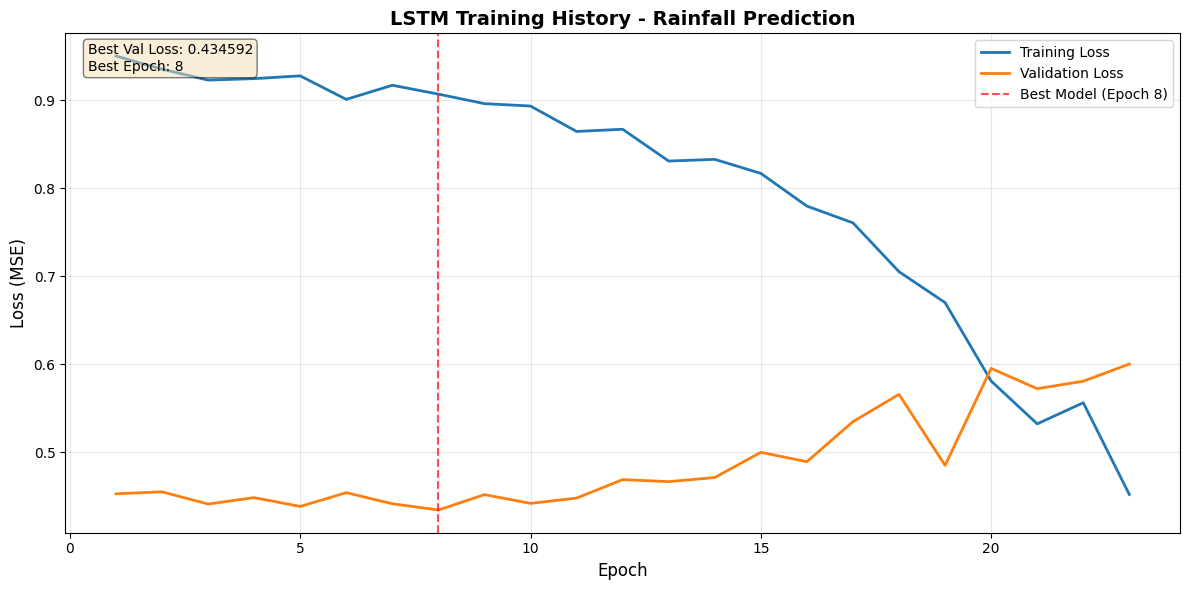

In [29]:
main()